# Clasificador de radiografías
<br>

## Detección de neumonía

In [1]:
#!pip install imblearn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm #barra de progreso
import cv2
from glob import glob

#para redimencionar
import sklearn
import skimage
from skimage.transform import resize

import random
import datetime

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray

# print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# comprobar conexion a la GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# directorios con las imagenes de entrenamiento y prueba
train_dir = 'drive/MyDrive/DeteccionNeumonia/chest_xray/train/'
test_dir =  'drive/MyDrive/DeteccionNeumonia/chest_xray/test/'

LOAD_FROM_IMAGES = False

def get_data(folder):
    X = []
    y = []
    
    # etiquetar radiografias (0 y 1)
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2

            # modificar radiografias
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                
                if img_file is not None:
                    # reescalar
                    img_file = skimage.transform.resize(img_file, (150,150,3), mode='constant', anti_aliasing=True)
                    # imagen en gris (blanco y negro)
                    img_file = rgb2gray(img_file)
                    # transformar imagen a un array de numpy
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    
    # array de numpy con los datos de todas las imagenes                
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y


if LOAD_FROM_IMAGES:
    # cargar las imagenes a los arrays
    X_train, y_train = get_data(train_dir)
    X_test, y_test = get_data(test_dir)
    
    # grabar los arrays en archivos
    np.save('drive/MyDrive/DeteccionNeumonia/xtrain.npy', X_train)
    np.save('drive/MyDrive/DeteccionNeumonia/ytrain.npy', y_train)
    np.save('drive/MyDrive/DeteccionNeumonia/xtest.npy', X_test)
    np.save('drive/MyDrive/DeteccionNeumonia/ytest.npy', y_test)
    
else:
    # cargar los arrays anteriormente grabados
    X_train = np.load('drive/MyDrive/DeteccionNeumonia/xtrain.npy')
    y_train = np.load('drive/MyDrive/DeteccionNeumonia/ytrain.npy')
    X_test = np.load('drive/MyDrive/DeteccionNeumonia/xtest.npy')
    y_test = np.load('drive/MyDrive/DeteccionNeumonia/ytest.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


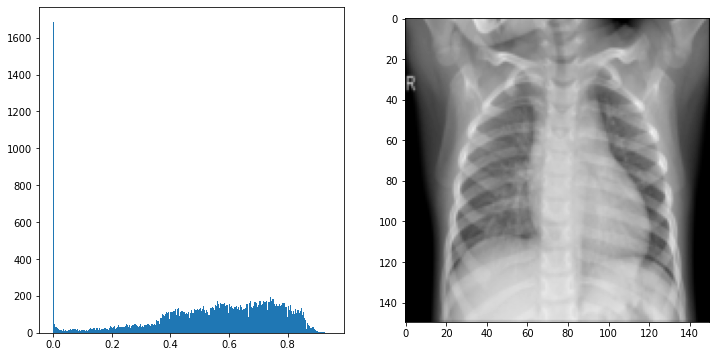

In [5]:
# histograma para una radiografia
def plotHistogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(a.ravel(), bins=255)
    plt.subplot(1,2,2)
    plt.imshow(a, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
plotHistogram(X_train[5])

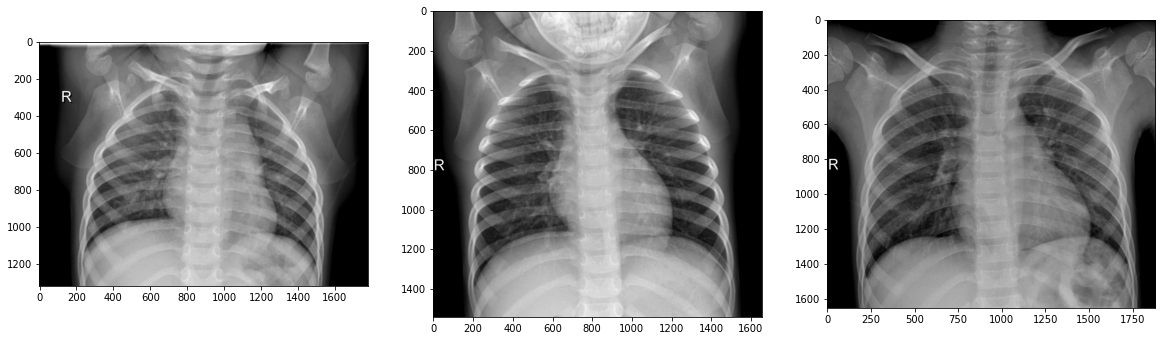

In [6]:
# mostrar varias imagenes (radiografias)
multipleImages = glob('drive/MyDrive/DeteccionNeumonia/chest_xray/train/NORMAL/**')

def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]));
    
plotThreeImages(multipleImages)

No Neumonia


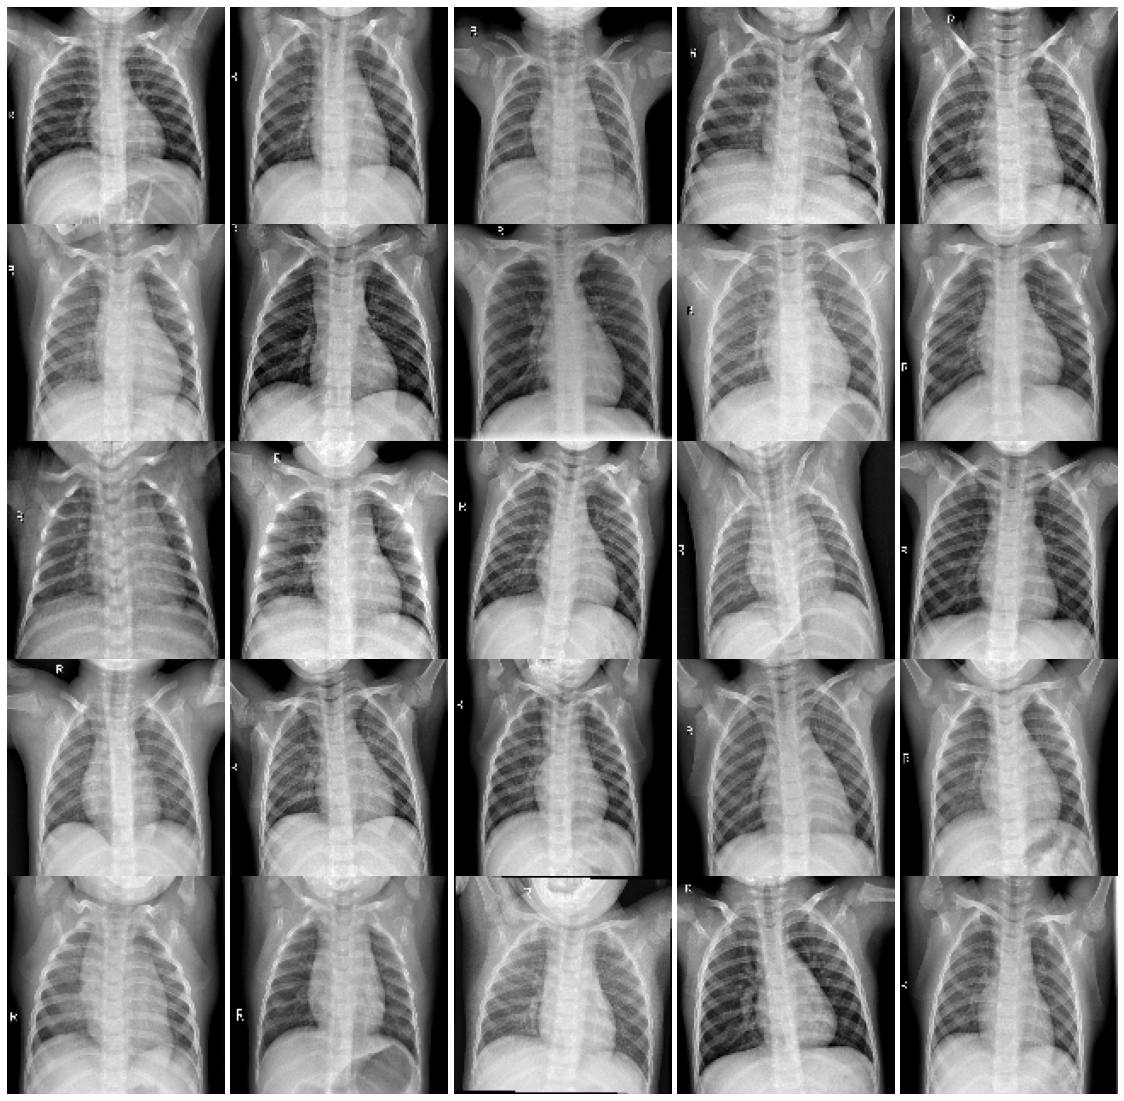

In [7]:
print('No Neumonia')

multipleImages = glob('drive/MyDrive/DeteccionNeumonia/chest_xray/train/NORMAL/**')
i_ = 0

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)

for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128,128))
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Si Neumonia


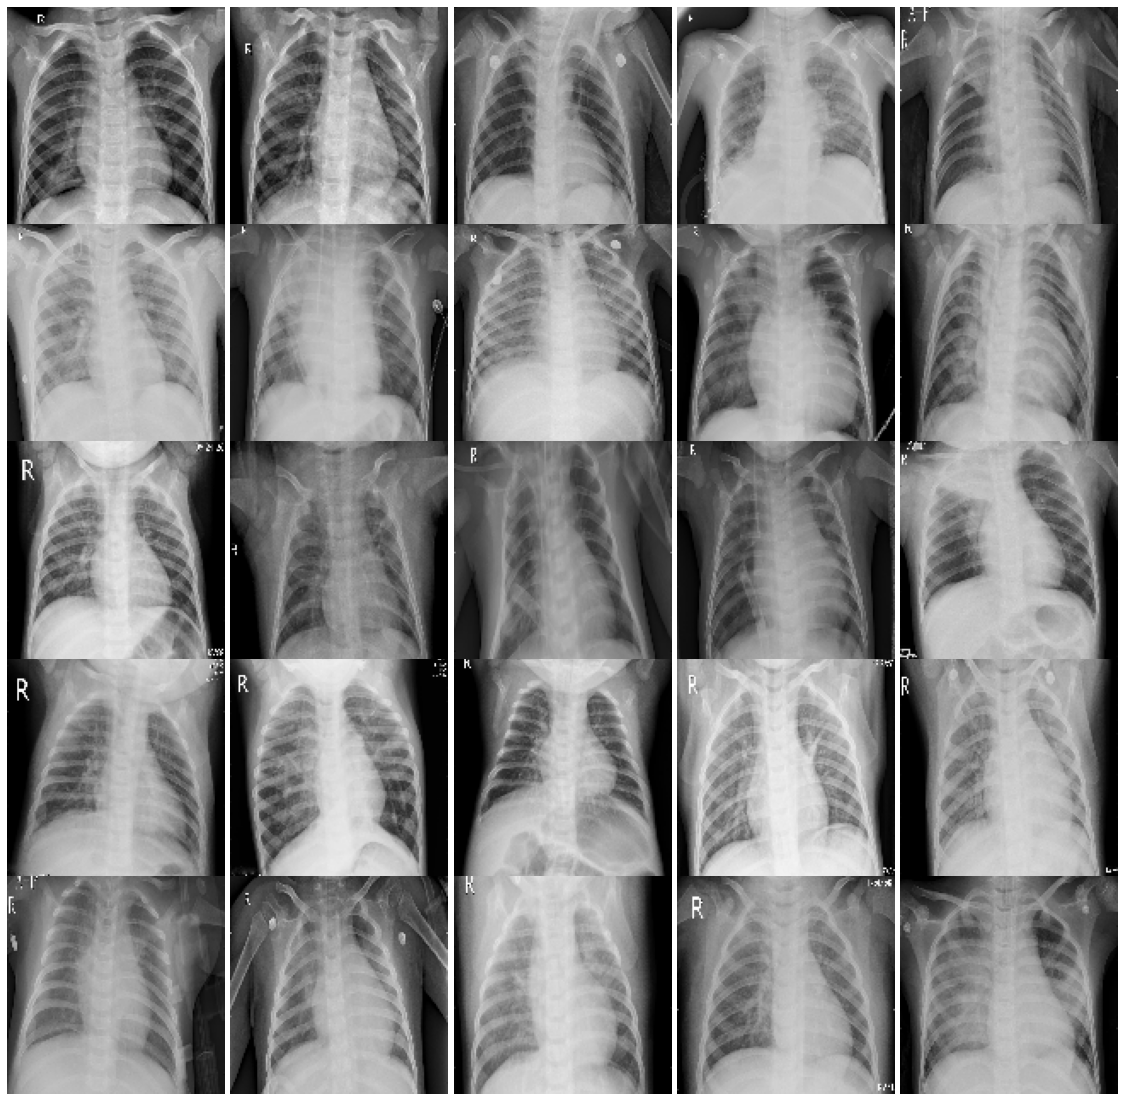

In [8]:
print('Si Neumonia')

multipleImages = glob('drive/MyDrive/DeteccionNeumonia/chest_xray/train/PNEUMONIA/**')
i_ = 0

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)

for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128,128))
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'No Neumonia', 1: 'Si Neumonia'}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


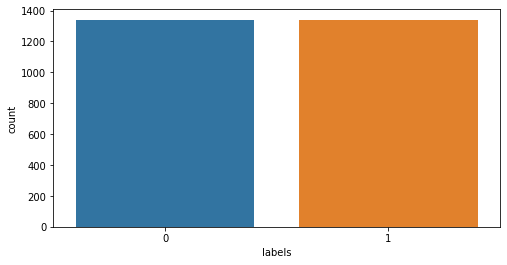

In [9]:
import seaborn as sns

plt.figure(figsize=(8,4))
map_characters = {0: 'No Neumonia', 1: 'Si Neumonia'}
dict_characters = map_characters

df = pd.DataFrame()
df['labels'] = y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [10]:
"""
X_trainReshaped.shape
y_train
"""
X_train.shape

(2682, 150, 150)

In [11]:
X_trainReshaped = X_train.reshape(len(X_train),150,150,1)
X_testReshaped = X_test.reshape(len(X_test),150,150,1)

X_trainReshaped.shape

(2682, 150, 150, 1)

In [12]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = 'drive/MyDrive/DeteccionNeumonia/chekpoints2/check'
cp_callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, 
                                                  save_weights_only=True, verbose=1)

model.fit(X_trainReshaped,
          y_train,
          epochs=20,
          batch_size=4,
          validation_data = (X_testReshaped, y_test),
          callbacks = [cp_callbacks])

Epoch 1/20
2682/2682 [==============================] - 12s 3ms/step - loss: 0.7074 - accuracy: 0.5191 - val_loss: 0.6976 - val_accuracy: 0.3750

Epoch 00001: saving model to drive/MyDrive/DeteccionNeumonia/chekpoints2/check
Epoch 2/20
2682/2682 [==============================] - 9s 3ms/step - loss: 0.6925 - accuracy: 0.5210 - val_loss: 0.6866 - val_accuracy: 0.6250

Epoch 00002: saving model to drive/MyDrive/DeteccionNeumonia/chekpoints2/check
Epoch 3/20
2682/2682 [==============================] - 9s 3ms/step - loss: 0.6937 - accuracy: 0.4984 - val_loss: 0.6898 - val_accuracy: 0.6250

Epoch 00003: saving model to drive/MyDrive/DeteccionNeumonia/chekpoints2/check
Epoch 4/20
2682/2682 [==============================] - 9s 3ms/step - loss: 0.6935 - accuracy: 0.5028 - val_loss: 0.6961 - val_accuracy: 0.3750

Epoch 00004: saving model to drive/MyDrive/DeteccionNeumonia/chekpoints2/check
Epoch 5/20
2682/2682 [==============================] - 9s 3ms/step - loss: 0.6934 - accuracy: 0.4826 -

In [14]:
test_loss, test_acc = model.evaluate(X_testReshaped, y_test)
print(test_acc)

20/20 [==============================] - 1s 21ms/step - loss: 0.6930 - accuracy: 0.6250
0.625


In [15]:
test_loss, test_acc = model.evaluate(X_trainReshaped, y_train)

84/84 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5000


## Prediccion

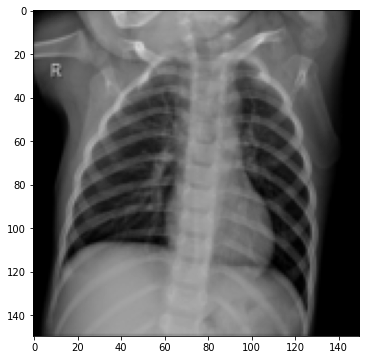

In [16]:
test_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg')
# test_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg')

np_test_image = np.array(test_image)

# reescalar
np_test_image = skimage.transform.resize(np_test_image, (150,150,3), mode='constant', anti_aliasing=True)
# imagen en gris (blanco y negro)
np_test_image = rgb2gray(np_test_image)

plt.figure(figsize=(12,6))
plt.imshow(np_test_image, cmap='gray', vmin=0, vmax=1)
plt.show()

In [17]:
np_test_image = np_test_image.reshape(1,150,150,1)

np_test_image.shape

(1, 150, 150, 1)

In [18]:
resultado = model.predict(np_test_image)
resultado[0]

array([0.49960795, 0.500392  ], dtype=float32)

Neumonia


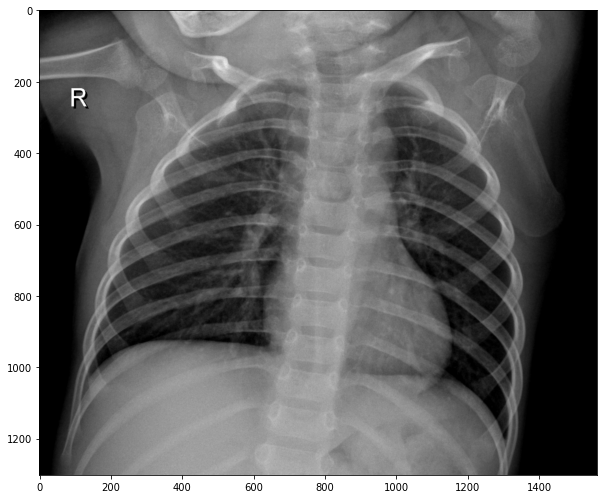

In [19]:
prediccion = np.argmax(resultado[0])

if prediccion == 0:
    print('Normal')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()
else:
    print('Neumonia')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()

## Entrenamiento usando los pesos guardados

In [20]:
model2 = models.Sequential()

model2.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Conv2D(64, (3,3), activation='relu'))


model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

In [21]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# precision antes de cargar los pesos 
loss, acc = model2.evaluate(X_testReshaped, y_test)
print(acc)

20/20 [==============================] - 0s 15ms/step - loss: 0.6754 - accuracy: 0.8889
0.625


In [23]:
# os.chdir(r'drive/MyDrive/DeteccionNeumonia')
# os.getcwd()

In [24]:
# cargar los pesos desde el archivo guardado

checkpoint_path = 'drive/MyDrive/DeteccionNeumonia/chekpoints/check'
model2.load_weights(checkpoint_path)
model2.save('drive/MyDrive/DeteccionNeumonia/rnc_model3.h5') # Guardar el modelo completo
loss, acc = model2.evaluate(X_testReshaped, y_test)
print(acc)

20/20 [==============================] - 0s 14ms/step - loss: 1.0439 - accuracy: 0.8253
0.8253205418586731


### Cargar modelo completo guardado (.h5)

In [34]:
# Hacer predicciones con el modelo completo guardado
from tensorflow.keras.models import load_model
model2 = load_model('drive/MyDrive/DeteccionNeumonia/rnc_model3.h5')

In [35]:
model2.summary()
loss, acc = model2.evaluate(X_testReshaped, y_test)
print(acc)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

### Hacer predicciones

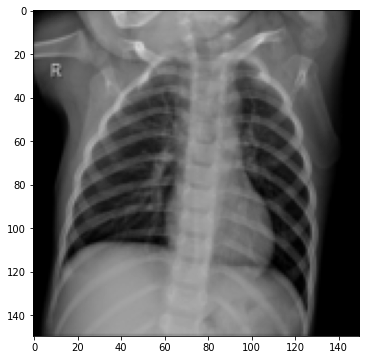

In [36]:
test_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg')
# test_image = cv2.imread('drive/MyDrive/DeteccionNeumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg')

np_test_image = np.array(test_image)

# reescalar
np_test_image = skimage.transform.resize(np_test_image, (150,150,3), mode='constant', anti_aliasing=True)
# imagen en gris (blanco y negro)
np_test_image = rgb2gray(np_test_image)

plt.figure(figsize=(12,6))
plt.imshow(np_test_image, cmap='gray', vmin=0, vmax=1)
plt.show()

In [37]:
np_test_image = np_test_image.reshape(1,150,150,1)

np_test_image.shape

(1, 150, 150, 1)

In [38]:
resultado = model2.predict(np_test_image)
resultado[0]

array([9.9999881e-01, 1.2440936e-06], dtype=float32)

Normal


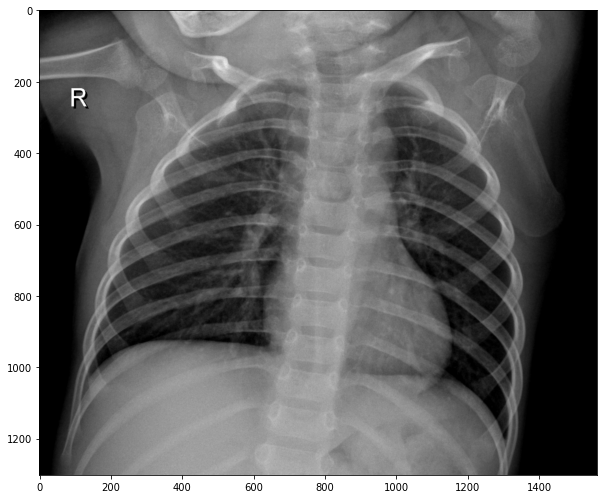

In [39]:
prediccion = np.argmax(resultado[0])

if prediccion == 0:
    print('Normal')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()
else:
    print('Neumonia')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()
